In [1]:
import pandas as pd
import numpy as np

from typing import List, Set

In [244]:
cognate = pd.read_csv("Grollemund_Data_Cognate.csv", index_col=0)
phonetic = pd.read_csv("Grollemund_Data_Phoneme.csv", index_col=0)
features = pd.read_csv("Chomsky_Halle_Features.csv", index_col=0)

clade_file = open('Clades.txt', 'r').readlines()
clades = {i.split(',')[0] : [j.strip() for j in i.split(',')[1:]] for i in clade_file}
    
all_phonemes = list(features.columns)[0:]

feature_matrix = pd.DataFrame(0, index=all_phonemes, columns=all_phonemes)

for phoneme1 in all_phonemes:
    for phoneme2 in all_phonemes:
        for (f, g) in zip(features.loc[:,phoneme1], features.loc[:,phoneme2]):
            if(not pd.isnull(f) and not pd.isnull(g) and f != g):
                # basically gets the Manhattan distance between two feature vectors
                feature_matrix.loc[phoneme1, phoneme2] += 1

learn_matrix = pd.read_csv('golden_newdist.csv', index_col=0)

In [202]:
import time
from scipy.spatial.distance import pdist

class CognateDistance:
    '''
    Gets distance between two cognate labels.


    Parameters
    ----------
    difference_cost
    '''
        
    def __init__(self, difference_cost: float = 1.):
        self._difference_cost = difference_cost
    
    def __call__(self, source: str, target: str) -> float:
        if (source == '?' or target == '?'): # if there's no data, assume maximum possible distance
            return 1.
        elif (source == target):
            return 0. 
        else:
            return self._difference_cost
    
    def common_words(self, lang1: str, lang2: str) -> int:
        common = 0
        
        for i, j in zip(cognate.loc[lang1], cognate.loc[lang2]):
            if(i != '?' and j !='?'):
                common += 1
                
        return common
    
    def distance_matrix(self, word: str) -> pd.core.frame.DataFrame:
        strings = np.array(list(cognate.loc[:,word]), dtype=object).reshape(-1,1)
        
        matrix = pdist(strings, lambda x, y: self(x[0], y[0]))

        return matrix
    
    def full_distance_matrix(self, phonemes: List[str]) -> np.array:
        full_matrix = np.zeros(int(len(cognate.index) ** 2 / 2 - len(cognate.index) / 2))
        for word in cognate.columns:
            full_matrix = np.add(full_matrix, self.distance_matrix(word))
            print(word)
        return full_matrix
    
class StringDistance:
    '''
    Gets the phonetic distance between strings.


    Parameters
    ----------
    insertion_cost
    deletion_cost
    cost_matrix
        an n by n matrix that contains a distance value between every phoneme
    '''
    
    def __init__(self, cost_matrix: pd.DataFrame, insertion_cost: float = 1.,
                 deletion_cost: float = 1.):
        self._insertion_cost = insertion_cost
        self._deletion_cost = deletion_cost
        # the dataframe looks nicer, but using a dictionary is several times faster in the actual function
        self.cost_matrix = cost_matrix.to_dict()

    def __call__(self, source: str, target: str) -> float:
        """
        Returns the distance between two strings.

        Parameters
        ----------
        source
        target
        """
        return self._wagner_fischer(source, target)
    
    def string_to_phonemes(self, string: str, phonemes: List[str]) -> List[str]:
        """
        Returns the distance between two strings.

        Parameters
        ----------
        source
        target
        """
        ordered_phonemes = list(sorted(phonemes, key = len))
        # this gets a list where the longest multigraphs appears first
        ordered_phonemes.reverse() 
        
        '''
        The data is formatted so that the class prefix is separated by a hyphen. 
        This should get the main roots whether these are hyphens or not.
        '''
        
        stem = string.split('-')
        
        if(len(stem) > 1):
            string = stem[1]
        else:
            string = stem[0]
        
        phoneme_list = list()
        i = 0
        while(i < len(string)):
            for p in ordered_phonemes:
                if(len(string) - i >= len(p) and string[i:i + len(p)] == p):
                    phoneme_list.append(p)
                    i += len(p)
                    break
                #if any character isn't part of the list of phonemes, ignore it
                elif(i < len(string) and string[i] not in phonemes):
                    i += 1
                    break
        return phoneme_list

    def _wagner_fischer(self, source: List[str], target: List[str]) -> float:
        '''
        Gets the Wagner–Fischer distance between two lists that represent strings.
        Based on the implementation found here:    
        https://www.codeproject.com/Articles/5342019/An-Optimal-Wagner-Fischer-Algorithm-For-Approximat
        
        Parameters
        ----------
        source
        target
        
        '''
        n, m = len(source), len(target)
        """
        Returns a distance of zero if source and target are equal.
        If only one string is present, the distance is equal to the length times the insertion cost
        per 
        """
        if source == target: 
            return 0.
        elif source == []:
            return self._insertion_cost * n
        elif target == []:
            return self._insertion_cost * m
        
        e_d = np.arange(m, dtype=float)
        
        for i in range(1, n):
            e_i = np.concatenate(([i], np.zeros(m - 1, dtype=float)))
            
            for j in range(1, m):
            
                if source[i] == target[j]:
                    substitution_cost = 0.
                else:
                    substitution_cost = self.cost_matrix[source[i]][target[j]]
                    
                e_i[j] = min(e_d[j] + self._deletion_cost,
                             e_i[j - 1] + self._insertion_cost,
                             e_d[j - 1] + substitution_cost)
                
            e_d = np.array(e_i, copy=True)
                    
        # adjusts the distance by dividing by the length on the longest lexical item
        return e_d[len(e_d) - 1] / max(n, m)
    
    def distance_matrix(self, word: str, phonemes: List[str], square=False) -> pd.core.frame.DataFrame:
        strings = [self.string_to_phonemes(i, phonemes) for i in list(phonetic.loc[:,word])]
        strings = np.array(strings, dtype=object).reshape(-1,1)
        
        matrix = pdist(strings, lambda x, y: self(x[0], y[0]))
        
        if(square):
            return pd.DataFrame(squareform(matrix), columns=phonetic.index, index=phonetic.index).rename_axis(index=None)
        else:
            return matrix
        
    def full_distance_matrix(self, phonemes: List[str]) -> np.array:
        full_matrix = np.zeros(int(len(phonetic.index) ** 2 / 2 - len(phonetic.index) / 2))
        for word in phonetic.columns:
            start = time.time()
            full_matrix = np.add(full_matrix, self.distance_matrix(word, phonemes))
            end = time.time()
            #print(word, "ellapsed: " + str(round(end - start, 2)) + " seconds")
        return full_matrix

In [203]:
import random
import time

max_score = 0
first = True
rand_matrix = None

while(True):
    rand_matrix = learn_matrix.copy()
    start = time.time()
    if(not first):
        for i in range(0, 100):
            x = random.randint(0, 100)
            y = random.randint(0, 100)
            _rand = max(0.01, rand_matrix.iloc[x,y] + random.uniform(-0.5, 0.5)) 
            if(rand_matrix.iloc[x,y] != 0):
                rand_matrix.iloc[x,y] = _rand
                rand_matrix.iloc[y,x] = _rand
    phoneticdist = StringDistance(rand_matrix, 1., 1.)
    # note: running the phonetic_matrix take ~1.6 minutes
    phonetic_matrix = phoneticdist.full_distance_matrix(all_phonemes)
    PhoneticTree = Tree(phonetic_matrix, phonetic.index, 'ward')
    score = PhoneticTree(draw=False)
    if(score >= max_score):
        max_score = score
        learn_matrix = rand_matrix.copy()
        learn_matrix.to_csv(str(int(round(score, 2) * 100)) + '_newdist_' + time.strftime("%H%M%S") + '.csv')
    first = False
    print("Best Score: ", max_score, "ellapsed: " + str(round((time.time() - start) / 60, 2)) + " minutes")

KeyError: 217

In [ ]:
import random
import time

diff = learn_matrix.subtract(feature_matrix)
diffs = []


for i in range(diff.shape[0]): #iterate over rows
    for j in range(diff.shape[1]): #iterate over columns
        if(diff.iloc[i, j] != 0 and not (diff.iloc[i, j], learn_matrix.columns[j], learn_matrix.columns[i]) in diffs):
            diffs.append((diff.iloc[i, j], learn_matrix.columns[i], learn_matrix.columns[j]))
        
diffs = sorted(diffs, key=lambda x: abs(x[0]))
print(len(diffs))

max_score = 0.70
rand_matrix = None

for i in range(0, len(diffs), 5):
    group = diffs[i:i+5]
    rand_matrix = learn_matrix.copy()
    start = time.time()
    for g in group:
        rand_matrix.loc[g[1], g[2]] = feature_matrix.loc[g[1], g[2]].copy()
        rand_matrix.loc[g[2], g[1]] = feature_matrix.loc[g[2], g[1]].copy()
    phoneticdist = StringDistance(rand_matrix, 1., 1.)
    # note: running the phonetic_matrix take ~1.6 minutes
    phonetic_matrix = phoneticdist.full_distance_matrix(all_phonemes)
    PhoneticTree = Tree(phonetic_matrix, phonetic.index, 'ward')
    score = PhoneticTree(draw=False)
    if(score >= max_score):
        max_score = score
        learn_matrix = rand_matrix.copy()
        learn_matrix.to_csv('70_newdist.csv')
    print("Best Score: ", max_score, "ellapsed: " + str(round((time.time() - start) / 60, 2)) + " minutes")

1577
Tree score: 0.6172839506172841
Best Score:  0.7 ellapsed: 1.35 minutes
Tree score: 0.7012345679012347
Best Score:  0.7012345679012347 ellapsed: 1.37 minutes
Tree score: 0.562962962962963
Best Score:  0.7012345679012347 ellapsed: 1.26 minutes
Tree score: 0.5679012345679013
Best Score:  0.7012345679012347 ellapsed: 1.22 minutes
Tree score: 0.5777777777777778
Best Score:  0.7012345679012347 ellapsed: 1.59 minutes
Tree score: 0.5777777777777778
Best Score:  0.7012345679012347 ellapsed: 1.56 minutes
Tree score: 0.6098765432098767
Best Score:  0.7012345679012347 ellapsed: 1.51 minutes
Tree score: 0.5679012345679013
Best Score:  0.7012345679012347 ellapsed: 1.43 minutes
Tree score: 0.7012345679012347
Best Score:  0.7012345679012347 ellapsed: 1.53 minutes
Tree score: 0.5530864197530865
Best Score:  0.7012345679012347 ellapsed: 1.57 minutes
Tree score: 0.7012345679012347
Best Score:  0.7012345679012347 ellapsed: 1.44 minutes
Tree score: 0.5777777777777778
Best Score:  0.7012345679012347 el

Tree score: 0.5777777777777778
Best Score:  0.7012345679012347 ellapsed: 1.36 minutes
Tree score: 0.7012345679012347
Best Score:  0.7012345679012347 ellapsed: 1.41 minutes
Tree score: 0.7012345679012347
Best Score:  0.7012345679012347 ellapsed: 1.24 minutes
Tree score: 0.7012345679012347
Best Score:  0.7012345679012347 ellapsed: 1.26 minutes
Tree score: 0.7012345679012347
Best Score:  0.7012345679012347 ellapsed: 1.48 minutes
Tree score: 0.7012345679012347
Best Score:  0.7012345679012347 ellapsed: 1.55 minutes
Tree score: 0.6246913580246914
Best Score:  0.7012345679012347 ellapsed: 1.52 minutes
Tree score: 0.48148148148148145
Best Score:  0.7012345679012347 ellapsed: 1.46 minutes
Tree score: 0.7012345679012347
Best Score:  0.7012345679012347 ellapsed: 1.25 minutes
Tree score: 0.7012345679012347
Best Score:  0.7012345679012347 ellapsed: 1.34 minutes
Tree score: 0.7012345679012347
Best Score:  0.7012345679012347 ellapsed: 1.22 minutes
Tree score: 0.5530864197530865
Best Score:  0.7012345

In [228]:
phoneticdist = StringDistance(learn_matrix, 1., 1.)
# note: running the phonetic_matrix takes a few minutes
phonetic_matrix = phoneticdist.full_distance_matrix(all_phonemes)

In [51]:
cognatedist = CognateDistance()
cognate_matrix = cognatedist.full_distance_matrix(all_phonemes)

animal
arm
ashes
bark
bed
belly
big
bird
bite
blood
bone
breast
burn
child
cloud
come
count
die
dog
drink
ear
eat
egg
elephant
eye
face
fall
fat, oil
feather
fingernail
fire
fire-wood
fish
five
fly
four
give
goat
ground, soil
hair
head
hear
heart
horn
house
hunger
intestine
kill
knee
knife
know
leaf
leg
liver
louse
man
moon
mouth
name
navel
neck
night
nose
one
person
rain
road/path
root
salt
sand
see
send
shame
sing
skin
sky
sleep
smoke
snake
spear
steal
stone
sun
tail
ten
three
tongue
tooth
tree
two
urine
village
vomit
walk
war
water
wind
woman
dew
iron


In [238]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree

class Tree:

    def __init__(self, matrix, index, method=str):
        self.matrix = matrix
        self.index = index
        self.method = method

    def __call__(self, draw=True, golden_clades=True, score=True):
        clust = linkage(np.nan_to_num(self.matrix), method=self.method)

        if(draw):
            fig, ax = plt.subplots(figsize=(30, 100))
        
        if(golden_clades):
            labels = ["{}, ({})".format(i, ' '.join([c for c in clades if i in clades[c]])) 
                                                     for i in self.index]
        else:
             labels=[i for i in self.index]

        if(draw):
            dendrogram(clust, color_threshold=85., orientation='left', labels=labels)
            plt.show()
            fig.savefig("tree.png", format="png", dpi = 110)

        tree = to_tree(clust)
        
        _score = self.score_tree(tree)
        return _score
            
    def search_for_clade(self, tree, name, clade):
        _max = []
        self.search_clade_recurs(tree, name, clade, _max)
        node = max(_max, key=lambda x:x[1])[0] # gets the node with the max depth
        return node.pre_order(lambda x: self.index[x.id])

    def search_clade_recurs(self, node, name, clade, _list, depth=0):
        if not node:
            return None

        if(sum(i in node.pre_order(lambda x: self.index[x.id]) for i in clade) >= len(clade) * ((len(clade) - 1) / len(clade))):
            _list.append((node, depth))
            if set(node.pre_order(lambda x: self.index[x.id])) != set(clades[name]):
                self.search_clade_recurs(node.left, name, clade, _list, depth + 1)
                self.search_clade_recurs(node.right, name, clade, _list, depth + 1)

        return None

    def score_tree(self, tree, weigh=True, print_clades=False) -> float:
        score = 0
        total = 0
        claded_langs = [i for l in clades.values() for i in l] # only includes languages that are placed within a clade
        for clade in clades:
            clades_in_node = self.search_for_clade(tree, clade, clades[clade])
            missing_langs = len([l for l in clades[clade] if l not in clades_in_node])
            spurious_langs = len([l for l in clades_in_node if l not in clades[clade] and l in claded_langs])
            clade_score = max(0, 1 - (min(1, spurious_langs / len(clades[clade])) + missing_langs / len(clades[clade])))
            if(weigh):
                score += clade_score * (len(clades[clade]) / len(claded_langs))
            else:
                score += clade_score
            if(print_clades):
                print(clade + ": " + str(round(clade_score, 2)))

        if(weigh):
            print("Tree score: " + str(score))
            return score
        else:
            print("Tree score: " + str(round(score / len(clades.values()), 2)))
            return score / len(clades.values())

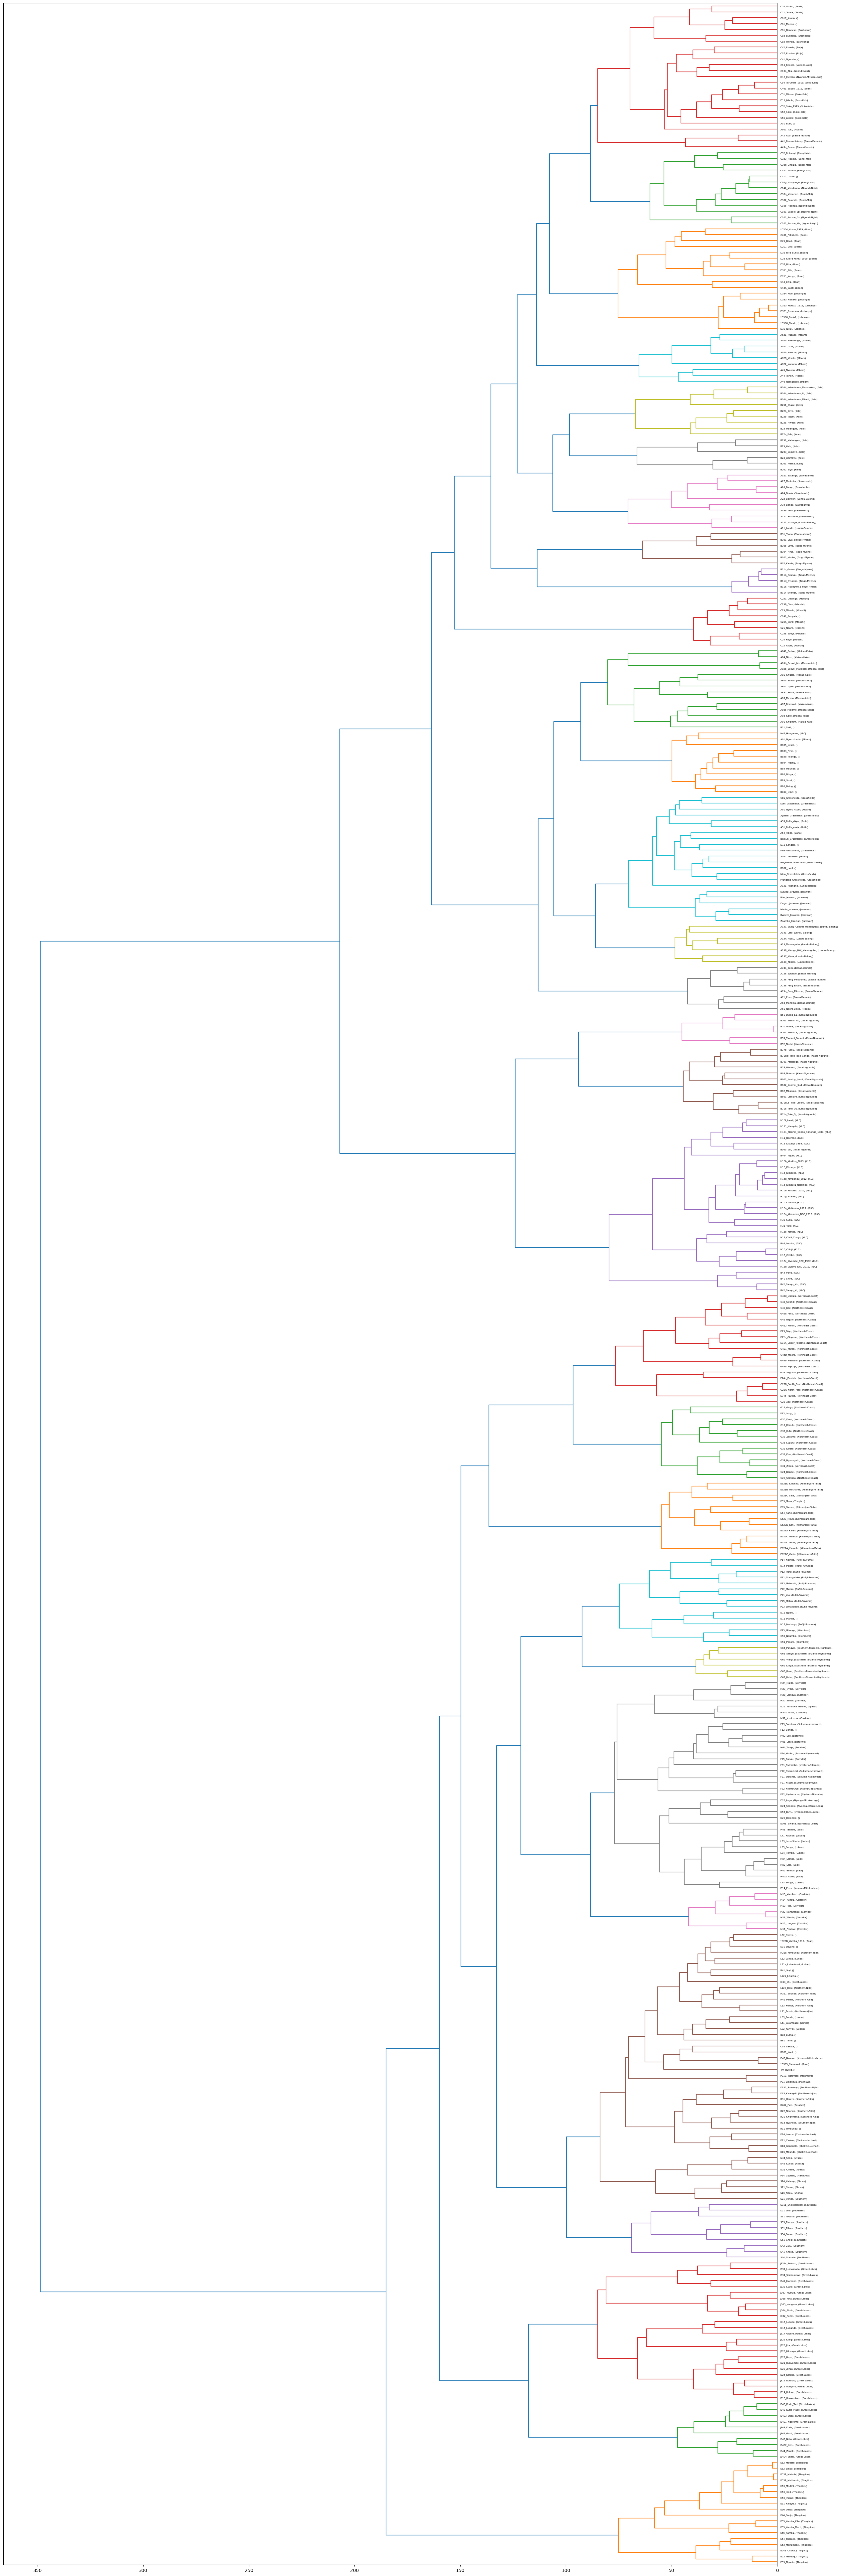

Grassfields: 0.38
Jarawan: 1.0
Lundu-Balong: 0
Sawabantu: 0.5
Basaa-Yaunde: 0
Mbam: 0
Bafia: 0.67
Makaa-Kako: 1.0
Tsogo-Myene: 1.0
Kele: 1.0
KLC: 0.93
Kasai-Ngounie: 0.95
Ngondi-Ngiri: 0
Mboshi: 1.0
Bangi-Moi: 0.57
Boan: 0
Buja: 1.0
Soko-Kele: 0.67
Tetela: 1.0
Bushoong: 0.67
Nyanga-Mituku-Lega: 0
Lebonya: 1.0
Thagiicu: 0.95
Kilimanjaro-Taita: 0.92
Northeast-Coast: 0.97
Sukuma-Nyamwezi: 0
Corridor: 0
Nyaturu-Nilamba: 0.67
Kilombero: 1.0
Southern-Tanzania-Highlands: 1.0
Northern-Njila: 0.83
Great-Lakes: 0.97
Chokwe-Luchazi: 1.0
Southern-Njila: 0.83
Botatwe: 0.75
Luban: 0
Lunda: 0.67
Sabi: 0.8
Rufiji-Ruvuma: 0.9
Nyasa: 0.75
Makhuwa: 0.67
Shona: 1.0
Southern: 0.91
Tree score: 0.7012345679012347


In [229]:
PhoneticTree = Tree(phonetic_matrix, phonetic.index, 'ward')
score = PhoneticTree(draw=True)

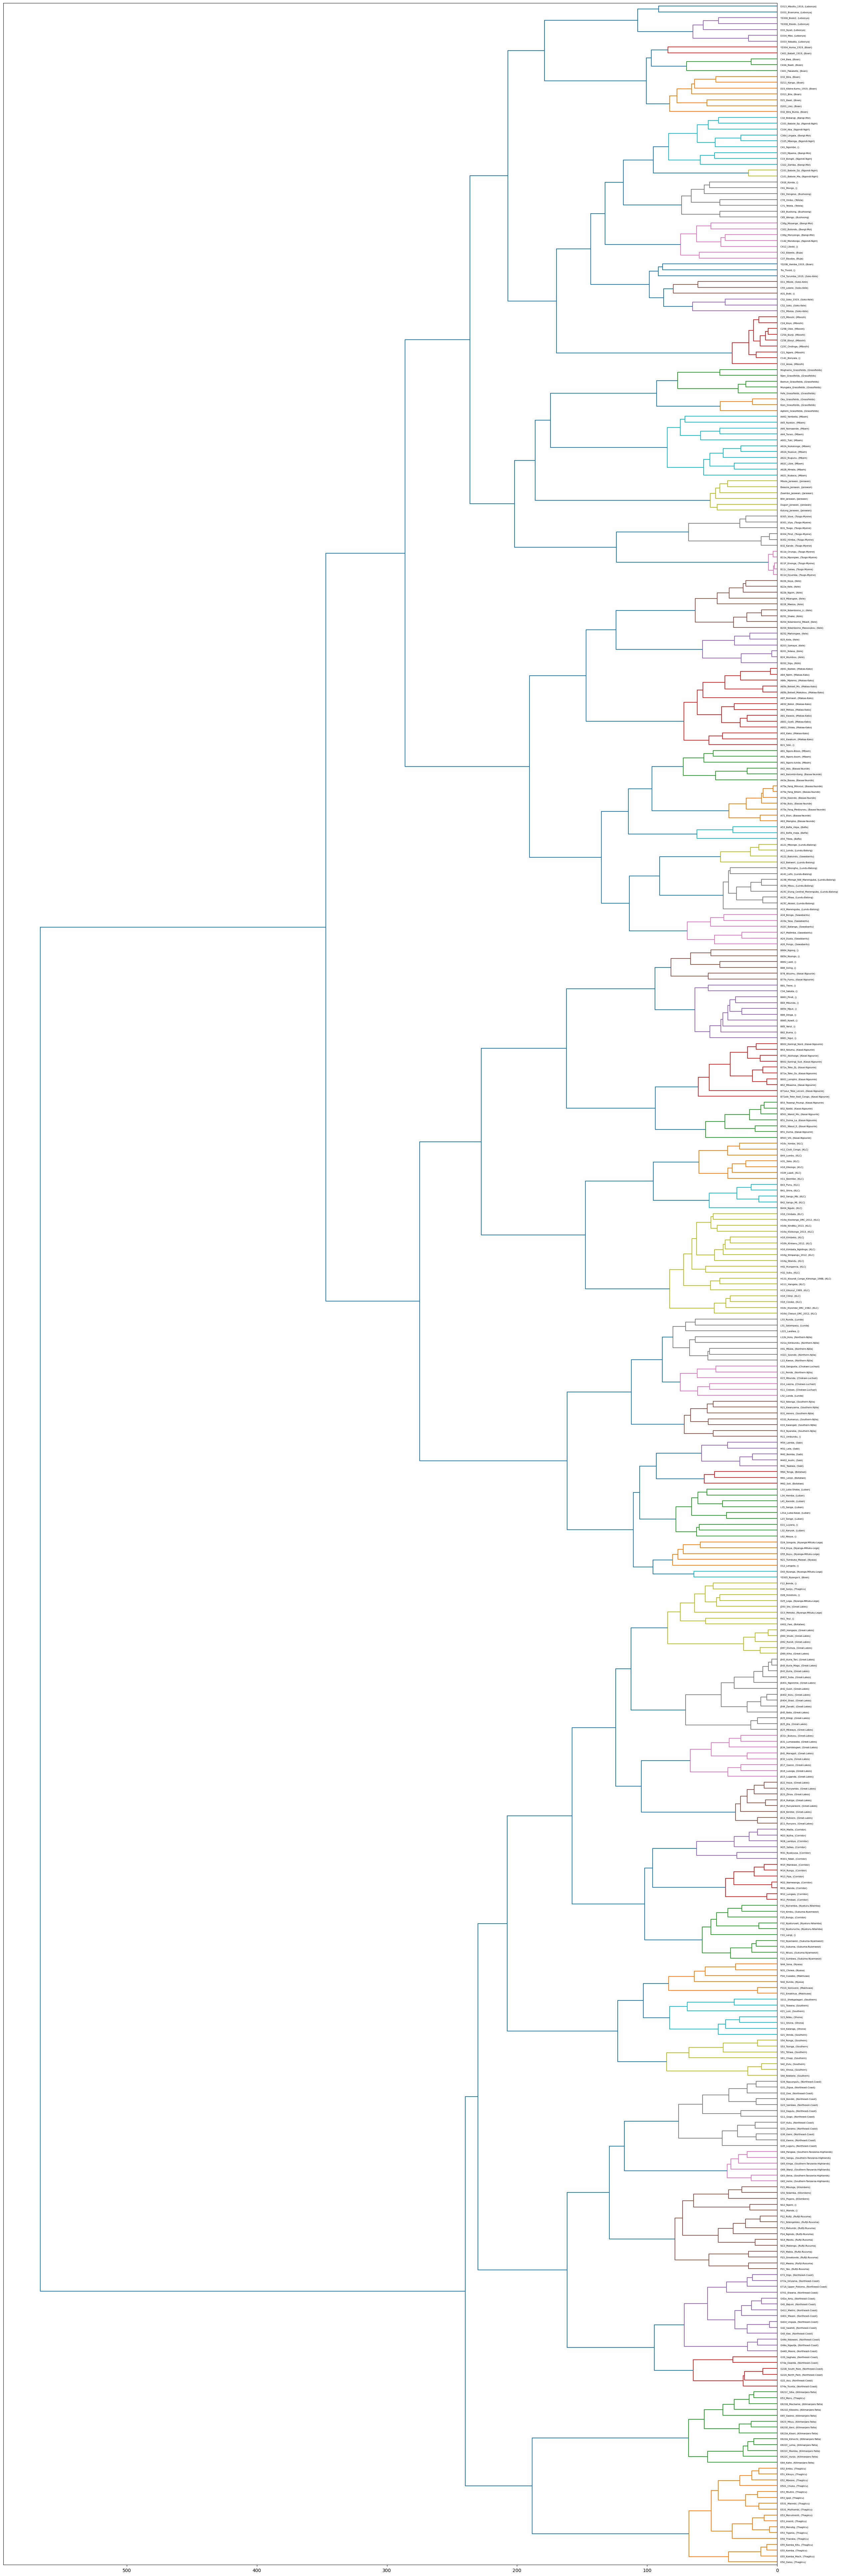

Grassfields: 1.0
Jarawan: 1.0
Lundu-Balong: 0.91
Sawabantu: 0
Basaa-Yaunde: 0.7
Mbam: 0
Bafia: 1.0
Makaa-Kako: 1.0
Tsogo-Myene: 1.0
Kele: 1.0
KLC: 1.0
Kasai-Ngounie: 1.0
Ngondi-Ngiri: 0.29
Mboshi: 0.88
Bangi-Moi: 0
Boan: 0
Buja: 1.0
Soko-Kele: 0.83
Tetela: 1.0
Bushoong: 0.67
Nyanga-Mituku-Lega: 0
Lebonya: 1.0
Thagiicu: 0.32
Kilimanjaro-Taita: 0.92
Northeast-Coast: 0.41
Sukuma-Nyamwezi: 0.8
Corridor: 0.93
Nyaturu-Nilamba: 0.67
Kilombero: 1.0
Southern-Tanzania-Highlands: 1.0
Northern-Njila: 0.83
Great-Lakes: 0.89
Chokwe-Luchazi: 0.5
Southern-Njila: 0.83
Botatwe: 0.75
Luban: 0.86
Lunda: 0.67
Sabi: 1.0
Rufiji-Ruvuma: 0.7
Nyasa: 0.5
Makhuwa: 0.67
Shona: 1.0
Southern: 0.18
Tree score: 0.6962962962962966


In [230]:
CognateTree = Tree(cognate_matrix, cognate.index, 'ward')
score = CognateTree()